In [8]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

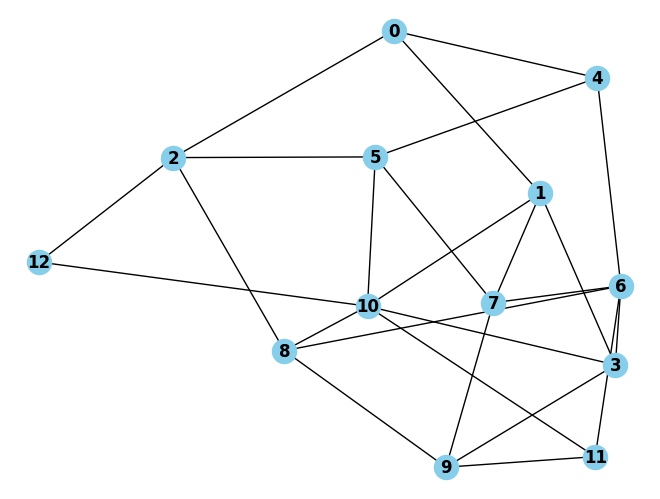

In [17]:
n = 13  # Number of nodes in the network
ingress_nodes = np.array([0, 2, 4, 6, 8, 10, 12])  # Example indices of ingress nodes in the network
computation_capacities = np.array([50, 60, 40, 30, 50, 40, 50, 60, 30, 40, 60, 40, 50])
storage_capacities = np.array([30, 40, 30, 20, 30, 20, 30, 40, 20, 30, 40, 30, 20])
traffic_rates = {0: 20, 2: 30, 4: 40}
bandwidths = np.array([
    [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
    [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
    [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
])
latencies = [
    [0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
]

G = nx.from_numpy_matrix(np.array(bandwidths))

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', font_weight='bold')
plt.show()

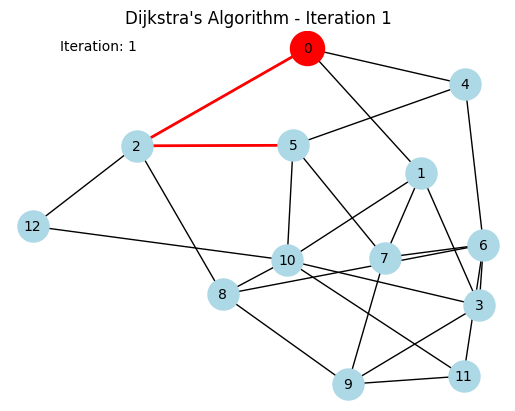

In [14]:
import matplotlib.animation as animation

# Create a graph from the bandwidth matrix
G = nx.from_numpy_matrix(bandwidths)

# Replace this with your Dijkstra's algorithm implementation
import heapq

def dijkstra_shortest_paths(graph, source):
    # Initialize distances dictionary and predecessor dictionary
    distances = {node: float('inf') for node in graph.nodes()}
    predecessors = {node: None for node in graph.nodes()}
    
    # The distance from the source node to itself is 0
    distances[source] = 0

    # Create a priority queue to store nodes and their distances
    priority_queue = [(0, source)]  # (distance, node)
    
    while priority_queue:
        # Get the node with the minimum distance from the queue
        current_distance, current_node = heapq.heappop(priority_queue)

        # Skip the node if we have found a better path to it already
        if current_distance > distances[current_node]:
            continue

        # Explore neighbors of the current node
        for neighbor in graph.neighbors(current_node):
            # Calculate the potential new distance
            potential_distance = current_distance + graph[current_node][neighbor]['weight']

            # If the potential distance is smaller than the current distance to the neighbor
            if potential_distance < distances[neighbor]:
                # Update the distance and predecessor
                distances[neighbor] = potential_distance
                predecessors[neighbor] = current_node
                # Add the neighbor to the priority queue
                heapq.heappush(priority_queue, (potential_distance, neighbor))

    return distances, predecessors

# Select a source and destination node for the shortest path
source_node = 0
destination_node = 5

# Run Dijkstra's algorithm to get the shortest paths
distances, predecessors = dijkstra_shortest_paths(G, source_node)
shortest_distance_to_destination = distances[destination_node]
shortest_path_to_destination = nx.shortest_path(G, source=source_node, target=destination_node, weight='weight')

def update(i):
    ax.clear()
    plt.title(f"Dijkstra's Algorithm - Iteration {i + 1}")

    # Draw nodes and edges
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

    # Highlight the current node being explored
    current_node = shortest_path_to_destination[min(i, len(shortest_path_to_destination) - 1)]
    nx.draw_networkx_nodes(G, pos, nodelist=[current_node], node_color='red', node_size=600)

    # Highlight the edges of the shortest path found so far
    edges = list(zip(shortest_path_to_destination, shortest_path_to_destination[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='red', width=2)

    # Show the number of iterations
    plt.text(0.1, 0.95, f"Iteration: {min(i + 1, len(shortest_path_to_destination))}", transform=ax.transAxes)

# Set up the animation
fig, ax = plt.subplots()
ani = animation.FuncAnimation(fig, update, frames=len(shortest_path_to_destination) + 1, interval=1000, repeat=False)

# Show the animation
plt.show()



In [15]:
def draw_network_graph(env, current_node):
    G = nx.Graph()

    # Add nodes with computation and storage capacities
    for i, node in enumerate(env.nodes):
        G.add_node(i, computation_capacity=node.computation_capacity, storage_capacity=node.storage_capacity)

    # Add edges with link bandwidth and latency
    for i in range(len(env.nodes)):
        for j in range(i+1, len(env.nodes)):
            if env.A[i][j] is not None:
                G.add_edge(i, j, bandwidth=env.A[i][j].bandwidth, latency=env.A[i][j].latency)

    # Set positions for nodes using spring layout
    pos = nx.spring_layout(G, seed=42)

    # Draw nodes with labels and node sizes based on capacities
    node_sizes = [150 + 1000 * np.log(node['computation_capacity'] * node['storage_capacity']) for _, node in G.nodes(data=True)]
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=node_sizes)
    labels = {node: f"Node {node}\nComp: {G.nodes[node]['computation_capacity']}\nStorage: {G.nodes[node]['storage_capacity']}" for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10)

    # Draw edges with labels and edge widths based on bandwidths
    edge_widths = [0.5 + 5 * np.log(link['bandwidth']) for _, _, link in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, width=edge_widths)
    edge_labels = {(i, j): f"Bandwidth: {G[i][j]['bandwidth']}\nLatency: {G[i][j]['latency']}" for i, j in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)

    # Highlight the current node being explored
    nx.draw_networkx_nodes(G, pos, nodelist=[current_node], node_color='red', node_size=600)

    # Show the plot
    plt.title("Network Graph Visualization")
    plt.axis('off')
    plt.show()

In [18]:
import random

class Node:
    def __init__(self, computation_capacity, storage_capacity):
        self.computation_capacity = computation_capacity
        self.storage_capacity = storage_capacity

class Link:
    def __init__(self, bandwidth, latency, utilization=0):
        self.bandwidth = bandwidth
        self.latency = latency
        self.utilization = utilization

def random_link_bandwidth():
    return random.uniform(10, 100)

def random_computation_capacity():
    return random.uniform(10, 60)

def random_storage_capacity():
    return random.uniform(10, 40)

def random_latency():
    return random.uniform(1, 20) # You can define the range for latency as needed

def random_traffic_rate():
    return random.uniform(10, 50)

class NetworkEnvironment:
    def __init__(self, n, ingress_nodes, computation_capacities, storage_capacities, bandwidths, latencies, traffic_rates):
        self.n = n
        self.ingress_nodes = ingress_nodes
        self.nodes = [Node(random_computation_capacity(), random_storage_capacity()) for _ in range(n)]
        self.A = [[None] * n for _ in range(n)]
        
        for i in range(n):
            for j in range(i+1, n):
                bandwidth = random_link_bandwidth()
                latency = random_latency()
                self.A[i][j] = self.A[j][i] = Link(bandwidth, latency)
                
        self.traffic_rates = {node_index: random_traffic_rate() for node_index in ingress_nodes}
        
    def reset(self):
        # code for resetting the environment to its initial state
        self.current_node = random.choice(self.ingress_nodes)
        self.destination_node = random.choice(list(set(range(self.n)) - set(self.ingress_nodes)))
        self.edges = {(i, j): {'utilization': 0} for i in range(self.n) for j in range(i+1, self.n)}
        
        
    def get_state(self):
        # Concatenate the feature vectors/matrices
        node_features = np.zeros((len(self.nodes), 2))
        for i, node in enumerate(self.nodes):
            node_features[i, 0] = node.computation_capacity
            node_features[i, 1] = node.storage_capacity
        
        link_bandwidth = np.zeros((len(self.nodes), len(self.nodes)))
        link_latency = np.zeros((len(self.nodes), len(self.nodes)))
        
        for i in range(len(self.nodes)):
            for j in range(len(self.nodes)):
                if self.A[i][j] is not None:
                    link_bandwidth[i, j] = self.A[i][j].bandwidth
                    link_latency[i, j] = self.A[i][j].latency

        traffic_rate_vector = np.array([self.traffic_rates[node_index] for node_index in self.ingress_nodes])

        state_representation = np.concatenate((node_features.flatten(),
                                               link_bandwidth.flatten(),
                                               link_latency.flatten(),
                                               traffic_rate_vector), axis=0)
       
        return self.current_node

    def get_available_actions(self, current_node):
        neighbors = [i for i, link in enumerate(self.A[current_node]) if link is not None]
        return neighbors

    def step(self, current_node, action):
        # Update link utilization based on the chosen action
        print(f"current_node: {current_node}, action: {action}, edges_keys: {self.edges.keys()}")
        link_utilization = self.edges[(current_node, action)]['utilization']
        self.edges[(current_node, action)]['utilization'] += self.traffic_rates[current_node]

        # Compute the reward using the reward function
        state = self.get_state()
        reward = reward_function(state, action, self)

        # Update current node and destination node
        self.current_node = action
        if self.current_node == self.destination_node:
            done = True
        else:
            done = False

        # Get the next state
        next_state = self.get_state()

        return next_state, reward, done


    def calculate_reward(self, current_node, action):
        next_node = action
        network = nx.Graph()

        for i in range(self.n):
            for j in range(i+1, self.n):
                if self.A[i][j] is not None:
                    network.add_edge(i, j, bandwidth=self.A[i][j].bandwidth,
                                     delay=self.A[i][j].latency,
                                     traffic_rate=self.A[i][j].utilization)

        # Calculate total network load (L_tot) and total network capacity (C_tot)
        L_tot = sum([network.edges[edge]['traffic_rate'] for edge in network.edges])
        C_tot = sum([network.edges[edge]['bandwidth'] for edge in network.edges])

        # Calculate bandwidth utilization reward (r_bu)
        r_bu = 1 - (L_tot / C_tot)

        # Calculate end-to-end delay reward (r_delay)
        source, destination = current_node, next_node
        path = nx.shortest_path(network, source, destination, weight='delay')
        total_delay = sum([network.edges[edge]['delay'] for edge in zip(path[:-1], path[1:])])
        D_avg = total_delay / len(path)

        K_n = [network.edges[edge]['bandwidth'] for edge in network.edges]
        U_n = [network.edges[edge]['traffic_rate'] for edge in network.edges]

        r_delay = 1 - (D_avg / sum([K / U for K, U in zip(K_n, U_n)]))

        # Calculate the final reward using the weight factor alpha
        alpha = 0.5
        reward = alpha * r_bu + (1 - alpha) * r_delay
        return reward

n = 13  # Number of nodes in the network
ingress_nodes = [0, 2, 4]  # Just an example, replace with actual indices of ingress nodes in your network

env = NetworkEnvironment( n, ingress_nodes, computation_capacities, storage_capacities, bandwidths, latencies, traffic_rates)

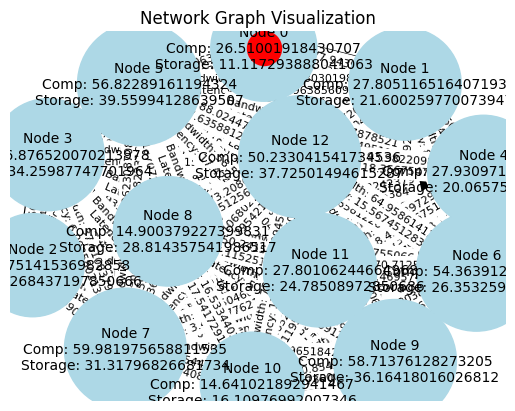

In [19]:
current_node = 0

# Visualize the network graph for the current state
draw_network_graph(env, current_node)


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import random

# Replace this class with your actual environment class
class NetworkEnvironment:
    def __init__(self, env, hidden_layers=[128, 64], gamma=0.99, epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.995, learning_rate=0.0005, buffer_size=10000, batch_size=64, update_frequency=4, tau=0.001, seed=42, state_size = 5, action_size = 5):
        self.n = n
        self.ingress_nodes = ingress_nodes
        self.computation_capacities = computation_capacities
        self.storage_capacities = storage_capacities
        self.bandwidths = bandwidths
        self.latencies = latencies
        self.traffic_rates = traffic_rates
        
        self.state_size = 2 * n + n * n * 2 + len(ingress_nodes)
        self.action_size = n

        self.nodes = {i: {'computation_capacity': computation_capacities[i], 'storage_capacity': storage_capacities[i],
                          'total_flows': 0} for i in range(n)}

        self.edges = {(i, j): {'bandwidth': bandwidths.get((i, j), 0), 'latency': latencies.get((i, j), 0), 'utilization': 0}
              for i in range(n) for j in range(n)}


        self.current_ingress_node = np.random.choice(ingress_nodes)
        
        
    def reset(self):
        # code for resetting the environment to its initial state
        self.current_node = random.choice(self.ingress_nodes)
        self.destination_node = random.choice(list(set(range(self.n)) - set(self.ingress_nodes)))
        self.edges = {(i, j): {'utilization': 0} for i in range(self.n) for j in range(i+1, self.n)}
        
        
    def get_state(self):
        # Concatenate the feature vectors/matrices
        node_features = np.zeros((len(self.nodes), 2))
        for i, node in enumerate(self.nodes):
            node_features[i, 0] = node.computation_capacity
            node_features[i, 1] = node.storage_capacity
        
        link_bandwidth = np.zeros((len(self.nodes), len(self.nodes)))
        link_latency = np.zeros((len(self.nodes), len(self.nodes)))
        
        for i in range(len(self.nodes)):
            for j in range(len(self.nodes)):
                if self.A[i][j] is not None:
                    link_bandwidth[i, j] = self.A[i][j].bandwidth
                    link_latency[i, j] = self.A[i][j].latency

        traffic_rate_vector = np.array([self.traffic_rates[node_index] for node_index in self.ingress_nodes])

        state_representation = np.concatenate((node_features.flatten(),
                                               link_bandwidth.flatten(),
                                               link_latency.flatten(),
                                               traffic_rate_vector), axis=0)
       
        return self.current_node

    def get_available_actions(self, current_node):
        neighbors = [i for i, link in enumerate(self.A[current_node]) if link is not None]
        return neighbors

    def step(self, current_node, action):
        # Update link utilization based on the chosen action
        print(f"current_node: {current_node}, action: {action}, edges_keys: {self.edges.keys()}")
        link_utilization = self.edges[(current_node, action)]['utilization']
        self.edges[(current_node, action)]['utilization'] += self.traffic_rates[current_node]

        # Compute the reward using the reward function
        state = self.get_state()
        reward = reward_function(state, action, self)

        # Update current node and destination node
        self.current_node = action
        if self.current_node == self.destination_node:
            done = True
        else:
            done = False

        # Get the next state
        next_state = self.get_state()

        return next_state, reward, done


    def calculate_reward(self, current_node, action):
        next_node = action
        network = nx.Graph()

        for i in range(self.n):
            for j in range(i+1, self.n):
                if self.A[i][j] is not None:
                    network.add_edge(i, j, bandwidth=self.A[i][j].bandwidth,
                                     delay=self.A[i][j].latency,
                                     traffic_rate=self.A[i][j].utilization)

        # Calculate total network load (L_tot) and total network capacity (C_tot)
        L_tot = sum([network.edges[edge]['traffic_rate'] for edge in network.edges])
        C_tot = sum([network.edges[edge]['bandwidth'] for edge in network.edges])

        # Calculate bandwidth utilization reward (r_bu)
        r_bu = 1 - (L_tot / C_tot)

        # Calculate end-to-end delay reward (r_delay)
        source, destination = current_node, next_node
        path = nx.shortest_path(network, source, destination, weight='delay')
        total_delay = sum([network.edges[edge]['delay'] for edge in zip(path[:-1], path[1:])])
        D_avg = total_delay / len(path)

        K_n = [network.edges[edge]['bandwidth'] for edge in network.edges]
        U_n = [network.edges[edge]['traffic_rate'] for edge in network.edges]

        r_delay = 1 - (D_avg / sum([K / U for K, U in zip(K_n, U_n)]))

        # Calculate the final reward using the weight factor alpha
        alpha = 0.5
        reward = alpha * r_bu + (1 - alpha) * r_delay
        return reward

# Copy the entire code for QNetwork, DQNAgent, and train_dqn() provided in the previous responses here.
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_layers=[128, 64], seed=42):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        self.layers.extend([nn.Linear(hidden_layers[i], hidden_layers[i+1]) for i in range(len(hidden_layers) - 1)])
        self.layers.append(nn.Linear(hidden_layers[-1], action_size))

    def forward(self, state):
        x = state
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        return self.layers[-1](x)

gamma = 0.99
epsilon_start = 1.0
epsilon_min = 0.01 
epsilon_decay = 0.995
learning_rate = 0.0005
buffer_size = 10000
batch_size = 64
update_frequency = 4
tau = 0.01
state_size = 5
action_size = 5

class DQNAgent:
    def __init__(self, env, hidden_layers=[128, 64], gamma=0.99, epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.995, learning_rate=0.0005, buffer_size=10000, batch_size=64, update_frequency=4, tau=0.001, seed=42):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.update_frequency = update_frequency
        self.tau = tau
        

        self.q_network = QNetwork(state_size, action_size, hidden_layers, seed).float()
        self.target_network = QNetwork(state_size, action_size, hidden_layers, seed).float()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)

        self.memory = deque(maxlen=buffer_size)
        self.steps = 0

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.choice(self.env.get_available_actions(self.env.current_node))
        else:
            state = torch.from_numpy(state).float().unsqueeze(0)
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train()
            return np.argmax(action_values.numpy())

    def step(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        self.steps += 1
        if self.steps % self.update_frequency == 0 and len(self.memory) >= self.batch_size:
            experiences = self.sample_experiences()
            self.learn(experiences)

    def sample_experiences(self):
        indices = np.random.choice(len(self.memory), self.batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.memory[idx] for idx in indices])
        states = torch.from_numpy(np.vstack(states)).float()
        actions = torch.from_numpy(np.vstack(actions)).long()
        rewards = torch.from_numpy(np.vstack(rewards)).float()
        next_states = torch.from_numpy(np.vstack(next_states)).float()
        dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).float()
        return states, actions, rewards, next_states, dones

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.target_network(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.q_network(states).gather(1, actions)

        # Compute loss
        loss = nn.functional.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update the target network
        self.soft_update(self.q_network, self.target_network, self.tau)

        # Update epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


    def train_dqn(env, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
        agent = DQNAgent(env)
        scores = []  # List containing scores from each episode
        scores_window = deque(maxlen=100)  # Last 100 scores
        eps = eps_start  # Initialize epsilon

        for i_episode in range(1, n_episodes + 1):
            env.reset()
            state = env.get_state()
            score = 0
            for t in range(max_t):
                action = agent.act(state)
                next_state, reward, done = env.step(action)
                agent.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break

        scores_window.append(score)  # Save the most recent score
        scores.append(score)  # Save the most recent score
        eps = max(eps_end, eps_decay * eps)  # Decrease epsilon
        agent.epsilon = eps  # Update the agent's epsilon

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        return scores

# Create an instance of your NetworkEnvironment
env = NetworkEnvironment(n, ingress_nodes, computation_capacities, storage_capacities, bandwidths, latencies, traffic_rates)

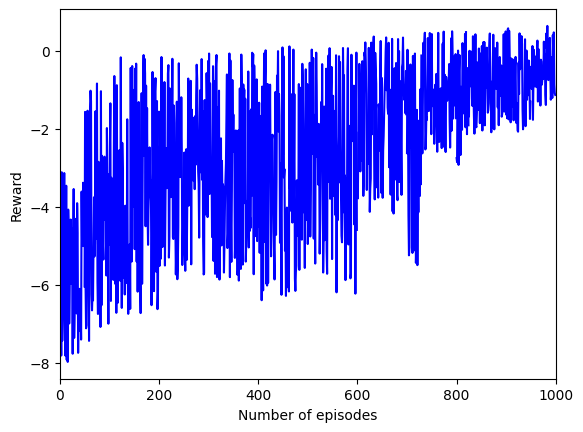

In [20]:
torch.save(agent.q_network.state_dict(), 'dqn_model.pth')
plt.show()